# Project 3 Web APIs and NLP 

In [31]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# seaborn plot styles

sns.set_style("dark")
sns.set_palette("deep")
plt.rcParams["axes.labelsize"] = 15
plt.rcParams["axes.titlesize"] = 20
myblue = '#0b5394'

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score

import pickle

from scipy.stats import uniform

#display all output form a cell not just the last (the options are 'all', 'none', 'last' and 'last_expr'.)

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import time

In [2]:
# reading in already cleaned data

data = pd.read_csv('../Data/reddit_data_clean.csv')
data.head(2)
data.shape
data.groupby('subreddit').count()

,subreddit,title,selftext,created_utc,author,num_comments,post_word_count,post_char_count,title_char_count,title_word_count
0,languagelearning,I would like to dedicate the rest of my 20s to...,(Age 24 from the USA) I've realized that the o...,1630453380,TheSweetOnion,25,298,1688,77,15
1,languagelearning,"Is it difficult because it's Korean, or is it ...",Thank you! Many of you answer my question. \n\...,1630450791,Altruistic-Ad-8788,2,36,249,95,16


(4036, 10)

,title,selftext,created_utc,author,num_comments,post_word_count,post_char_count,title_char_count,title_word_count
subreddit,,,,,,,,,
languagelearning,2015,2015,2015,2015,2015,2015,2015,2015,2015
linguistics,2021,2021,2021,2021,2021,2021,2021,2021,2021


## Baseline model

This section involves building two simple baseline models by considering the most common words that occur in one of the subreddits but not the other.

For each subreddit, a list of frequent words that occur in it but not frequently in the other is constructed. 

- Model 1: If a post contains at least one word from this list for r/languagelearning, it is classified to be from that r/languagelearning, else classified to be from r/linguistics. 
- Model 2: If a post contains at least one word from this list for r/linguistics, it is classified to be from that r/linguistics, else classified to be from r/languagelearning. 

These models were iterated for various lengths of the frequent words list.

Here are some interesting observations about the baseline models:


- Best Accuracies of these models were observed to be as follows:
    - Model 1: 0.74
    - Model 2: 0.61

- As expected, Model 1 did better on r/languagelearning while Model 2 did better on r/linguistics. Interestingly, Model 1 did better with a shorter list of prominent words whereas Model 2 did better with a longer list of prominent words.

- The top prominent words that featured in r/languagelearning not r/linguistics
    - when length of frequent words list = 10: 'learn', 'learning', 'spanish', 'time'
    - when length of frequent words list = 50: 'chinese', 'day', 'feel', 'grammar', 'italian', 'japanese', 'language learning'
- The top prominent words that featured in r/linguistics not r/languagelearning
    - when length of frquent words list = 10: 'https', 'people', 'word', 'words'
    - when length of frquent words list = 50: 'accent', 'ask', 'did', 'different', 'does', 'example', 'greek'

Note:

As this model is built to establish a baseline score, no train-test-split or cross-validation was done. The models were evaluated on the whole dataset.

In [3]:
accuracies = {'model_1' : [], 'model_2' : []}

for depth in range(10,105,5):

    df = data.copy()
    #baseline model

    cv = CountVectorizer(stop_words='english', ngram_range=(1,2))

    #vectorizing text column and making a DataFrame with the vectors

    vect = cv.fit_transform(df['title'] + ' ' + df['selftext'])
    vect_df = pd.DataFrame(vect.todense(), columns=cv.get_feature_names())

    #creating a disctionary of important words for each subreddit

    imp_words_dict = {'languagelearning' : [] , 'linguistics' : []}
    for subreddit in imp_words_dict.keys():    
        imp_words_dict[subreddit] = vect_df[df['subreddit'] == subreddit].sum().sort_values(ascending=False).head(depth).index.to_list()

    #creating lists of words that are prominent in one subreddit but not the other

    languagelearning_features = set(imp_words_dict['languagelearning'])-set(imp_words_dict['linguistics'])
    linguistics_features = set(imp_words_dict['linguistics'])-set(imp_words_dict['languagelearning'])

    #naive model

    df['set_of_words'] = (df['title']+ ' ' + df['selftext']).str.split(' ')
    df['model_1'] = df['set_of_words'].map(lambda x: 'languagelearning' if languagelearning_features.intersection(x) != set() else 'linguistics')
    df['model_2'] = df['set_of_words'].map(lambda x: 'linguistics' if linguistics_features.intersection(x) != set() else 'languagelearning')

    #model accuracy

    for x in ['model_1', 'model_2']:
        
        accuracies[x].append((df[x] == df['subreddit']).value_counts(normalize=True)[True])

In [17]:
#saving baseline accuracies
pickle.dump(pd.DataFrame(accuracies), open('../Data/baseline_accuracies.pkl', 'wb'))


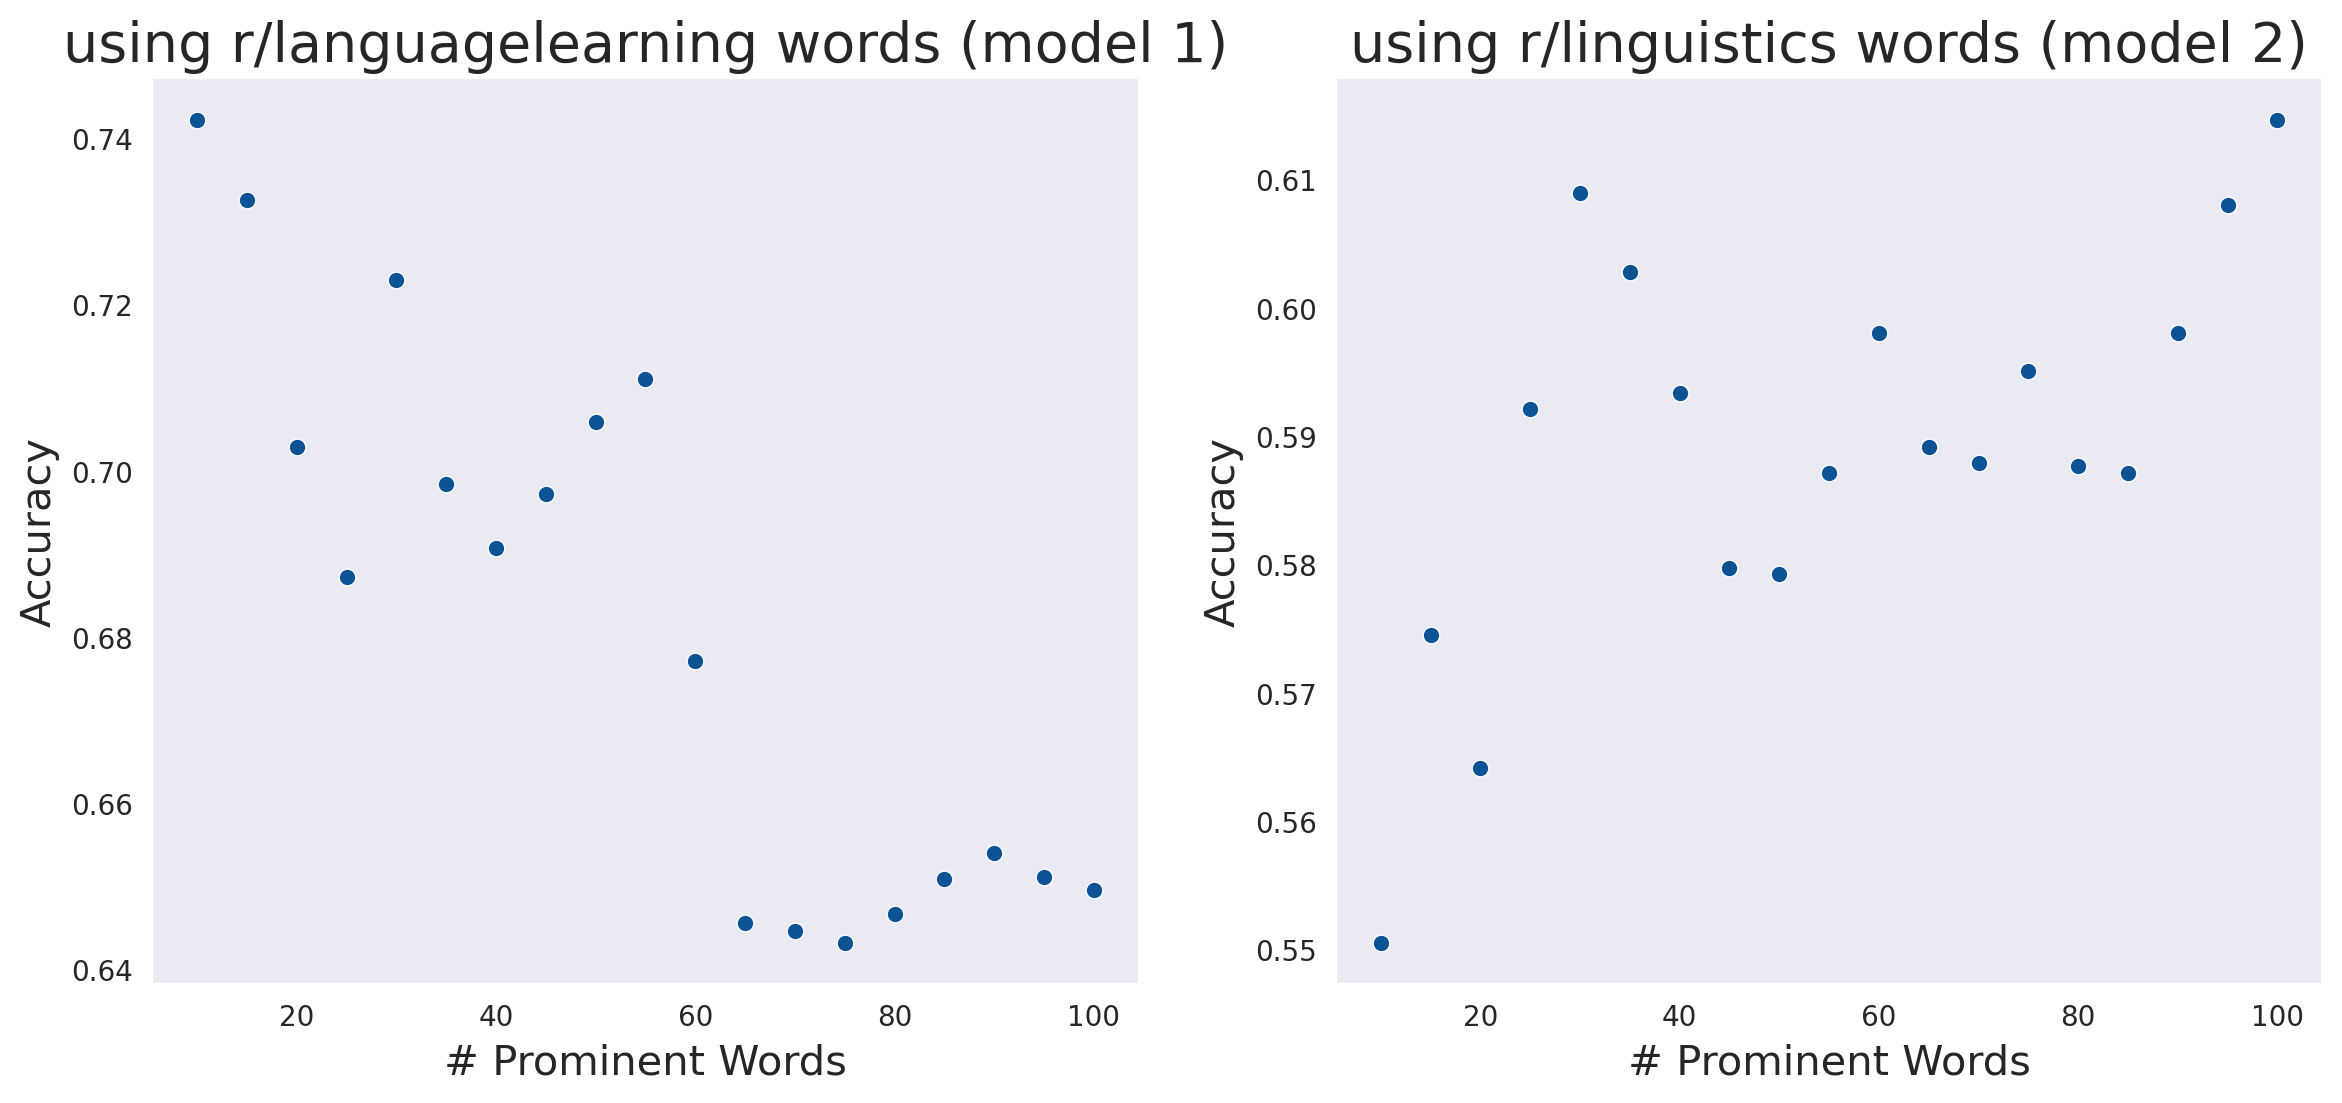

In [149]:
fig, ax = plt.subplots(1,2, figsize = (14,6), dpi = 200)
sns.scatterplot(x = range(10,105,5), y = accuracies['model_1']  , ax = ax[0], alpha = 1, color = myblue)
ax[0].set_title('using r/languagelearning words (model 1)')
ax[0].set_xlabel('# Prominent Words')
ax[0].set_ylabel('Accuracy'); 

sns.scatterplot(x = range(10,105,5), y = accuracies['model_2']  , ax = ax[1], alpha = 1, color = myblue)
ax[1].set_title('using r/linguistics words (model 2)')
ax[1].set_xlabel('# Prominent Words')
ax[1].set_ylabel('Accuracy'); 

## Comparison of the performance of various clasification models

### Random Forest Classifier

The posts were classified using three RandomForest models with different features.
- model 1 : using the title of the post
- model 2 : using the content (selftext) of the post
- model 3 : using both the title and content of the post

In [117]:
#helper function

#shorthand - r/ll is the subreddit languagelearning and r/lg is the subreddit linguistics

def rf_model_evaluation(X, y):
    '''
    For a text column X and target column y, run a grid search with a particular 
    set of parameters for countvectorizing X and fitting a random forest model and return an array with 
    [overall train score, overall test score, 
    r/ll train score, r/ll test score, 
    r/lg train score, r/lg test score,
    best parameters]
    
    TODO: Modify to pass estimator and params as arguments
    '''
    pipe = Pipeline([
        ('cvec', CountVectorizer()),
        ('rf', RandomForestClassifier())    
    ])

    pipe_params = {
        'cvec__max_features': [2000,3000,4000,5000],
        'cvec__min_df': [2, 3],
        'cvec__max_df': [0.9],
        'cvec__ngram_range': [(1,2)],
        'rf__n_estimators': [100, 200],
        'rf__max_depth': [4, 5],
        'rf__max_features': ['sqrt', .5]
    }

    gs = GridSearchCV(
        estimator = pipe,
        param_grid = pipe_params,
        cv = 3,
        n_jobs = -1,
        verbose = 1
    )

    #train-test-split

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

    #fitting and evaluating the model

    gs.fit(X_train, y_train)
    gs.score(X_train, y_train)
    gs.score(X_test, y_test)
    gs.best_params_
    
    #training accuracy by subreddit
    preds_df = pd.DataFrame({'true': y_train, 'preds' : gs.predict(X_train).tolist() })
    train_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    train_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']
    
    #testing accuracy by subreddit
    preds_df = pd.DataFrame({'true': y_test, 'preds' : gs.predict(X_test).tolist() })
    test_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    test_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']    
    return([
         gs.score(X_train, y_train),
         gs.score(X_test, y_test),
         train_ll, test_ll,
         train_lg, test_lg,
         gs.best_params_
        ])

In [124]:
rf_models_summary = {}
for i,X in enumerate([data['selftext'], data['title'], data['title']+ ' ' + data['selftext']]):
    rf_models_summary[f'model_{i+1}'] = rf_model_evaluation(X, data['subreddit'])
    

Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 64 candidates, totalling 192 fits
Fitting 3 folds for each of 64 candidates, totalling 192 fits


In [125]:
rf_models_summary

{'model_1': [0.8341592335645854,
  0.7888999008919723,
  0.7352746525479815,
  0.7043650793650794,
  0.9327176781002638,
  0.8732673267326733,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 4000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 2),
   'rf__max_depth': 5,
   'rf__max_features': 'sqrt',
   'rf__n_estimators': 200}],
 'model_2': [0.8123554674595309,
  0.7522299306243806,
  0.7518199867637326,
  0.6746031746031746,
  0.8726912928759895,
  0.8297029702970297,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 5000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 2),
   'rf__max_depth': 4,
   'rf__max_features': 'sqrt',
   'rf__n_estimators': 200}],
 'model_3': [0.8510075982821275,
  0.8087215064420218,
  0.7677035076108537,
  0.7341269841269841,
  0.9340369393139841,
  0.8831683168316832,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 5000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 2),
   'rf__max_depth': 5,
   'rf__max_features': 'sqrt',
   'rf__n_estimators':

### Gradient Boosting Classifier

In [126]:
#helper function modified for Gradient Boosting

def gb_model_evaluation(X, y):
    '''
    For a text column X and target column y, run a grid search with a particular 
    set of parameters for countvectorizing X and fitting a gradient boosting model and return an array with 
    [overall train score, overall test score, 
    r/ll train score, r/ll test score, 
    r/lg train score, r/lg test score,
    best parameters]
    
    TODO: Modify to pass estimator and params as arguments
    '''
    pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words='english')),
        ('gb', GradientBoostingClassifier(random_state = 42))    
    ])

    pipe_params = {
        'cvec__max_features': [2000,3000,4000,5000],
        'cvec__min_df': [2, 3],
        'cvec__max_df': [0.9],
        'cvec__ngram_range': [(1,2), (1,3)],
        'gb__n_estimators': [20, 50, 100],
        
    }

    gs = GridSearchCV(
        estimator = pipe,
        param_grid = pipe_params,
        cv = 3,
        n_jobs = -1,
        verbose = 1
    )

    #train-test-split

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

    #fitting and evaluating the model

    gs.fit(X_train, y_train)
    gs.score(X_train, y_train)
    gs.score(X_test, y_test)
    gs.best_params_
    
    #training accuracy by subreddit
    preds_df = pd.DataFrame({'true': y_train, 'preds' : gs.predict(X_train).tolist() })
    train_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    train_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']
    
    #testing accuracy by subreddit
    preds_df = pd.DataFrame({'true': y_test, 'preds' : gs.predict(X_test).tolist() })
    test_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    test_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']    
    return([
         gs.score(X_train, y_train),
         gs.score(X_test, y_test),
         train_ll, test_ll,
         train_lg, test_lg,
         gs.best_params_
        ])

In [127]:
gb_models_summary = {}
for i,X in enumerate([data['selftext'], data['title'], data['title']+ ' ' + data['selftext']]):
    gb_models_summary[f'model_{i+1}'] = gb_model_evaluation(X, data['subreddit'])
    

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits
Fitting 3 folds for each of 48 candidates, totalling 144 fits


In [128]:
gb_models_summary

{'model_1': [0.865213082259663,
  0.8136769078295342,
  0.7902051621442753,
  0.7361111111111112,
  0.9399736147757256,
  0.8910891089108911,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 2000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 3),
   'gb__n_estimators': 100}],
 'model_2': [0.7875784605219689,
  0.7304261645193261,
  0.6770350761085374,
  0.6051587301587301,
  0.8977572559366754,
  0.8554455445544554,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 2000,
   'cvec__min_df': 3,
   'cvec__ngram_range': (1, 3),
   'gb__n_estimators': 100}],
 'model_3': [0.8850346878097126,
  0.8334985133795837,
  0.8226340172071476,
  0.7757936507936508,
  0.9472295514511874,
  0.8910891089108911,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 3000,
   'cvec__min_df': 3,
   'cvec__ngram_range': (1, 2),
   'gb__n_estimators': 100}]}

### Voting Classifier

In [136]:
#helper function modified for Voting Classifier

def vc_model_evaluation(X, y):
    '''
    For a text column X and target column y, run a grid search with a particular 
    set of parameters for countvectorizing X and fitting a gradient boosting model and return an array with 
    [overall train score, overall test score, 
    r/ll train score, r/ll test score, 
    r/lg train score, r/lg test score,
    best parameters]
    
    TODO: Modify to pass estimator and params as arguments
    '''
    pipe = Pipeline([
        ('cvec', CountVectorizer(stop_words='english')),
        ('vote', VotingClassifier([
                                  ('ada', AdaBoostClassifier(random_state=42)),
                                  ('gb', GradientBoostingClassifier(random_state=42)),
                                  ('rf', RandomForestClassifier(random_state=42))
                                ])
        )    
                    ])

    pipe_params = {
        'cvec__max_features': [2000,3000,4000,5000],
        'cvec__min_df': [2, 3],
        'cvec__max_df': [0.9],
        'cvec__ngram_range': [(1,2), (1,3)],
        'vote__ada__base_estimator': [None],
        'vote__ada__n_estimators': [50, 95, 100],
        'vote__gb__n_estimators': [20, 50, 100],
        'vote__rf__max_depth': [5,6],
        'vote__rf__min_samples_split': [3,4]
        
    }

    gs = GridSearchCV(
        estimator = pipe,
        param_grid = pipe_params,
        cv = 3,
        n_jobs = -1,
        verbose = 1
    )

    #train-test-split

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

    #fitting and evaluating the model

    gs.fit(X_train, y_train)
    gs.score(X_train, y_train)
    gs.score(X_test, y_test)
    gs.best_params_
    
    #training accuracy by subreddit
    preds_df = pd.DataFrame({'true': y_train, 'preds' : gs.predict(X_train).tolist() })
    train_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    train_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']
    
    #testing accuracy by subreddit
    preds_df = pd.DataFrame({'true': y_test, 'preds' : gs.predict(X_test).tolist() })
    test_ll = preds_df[preds_df['true'] == 'languagelearning'].value_counts(normalize = True)['languagelearning','languagelearning']
    test_lg = preds_df[preds_df['true'] == 'linguistics'].value_counts(normalize = True)['linguistics','linguistics']    
    return([
         gs.score(X_train, y_train),
         gs.score(X_test, y_test),
         train_ll, test_ll,
         train_lg, test_lg,
         gs.best_params_
        ])

In [137]:
vc_models_summary = {}
for i,X in enumerate([data['selftext'], data['title'], data['title']+ ' ' + data['selftext']]):
    vc_models_summary[f'model_{i+1}'] = vc_model_evaluation(X, data['subreddit'])

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Fitting 3 folds for each of 576 candidates, totalling 1728 fits
Fitting 3 folds for each of 576 candidates, totalling 1728 fits


In [138]:
vc_models_summary

{'model_1': [0.8678559629996696,
  0.8166501486620417,
  0.7941760423560555,
  0.748015873015873,
  0.9412928759894459,
  0.8851485148514852,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 4000,
   'cvec__min_df': 2,
   'cvec__ngram_range': (1, 2),
   'vote__ada__base_estimator': None,
   'vote__ada__n_estimators': 95,
   'vote__gb__n_estimators': 100,
   'vote__rf__max_depth': 6,
   'vote__rf__min_samples_split': 3}],
 'model_2': [0.7938553022794846,
  0.7383548067393458,
  0.686962276637988,
  0.6130952380952381,
  0.9003957783641161,
  0.8633663366336634,
  {'cvec__max_df': 0.9,
   'cvec__max_features': 2000,
   'cvec__min_df': 3,
   'cvec__ngram_range': (1, 3),
   'vote__ada__base_estimator': None,
   'vote__ada__n_estimators': 100,
   'vote__gb__n_estimators': 100,
   'vote__rf__max_depth': 5,
   'vote__rf__min_samples_split': 3}],
 'model_3': [0.8893293690122234,
  0.8344895936570862,
  0.8252812706816678,
  0.7738095238095238,
  0.9531662269129287,
  0.8950495049504951,
  {'cv

In [ ]:
#curve of accuracy with n-grams: